In [1]:
# Importieren von Bibliotheken
import numpy as np 
from qiskit import *

from qiskit import Aer
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram

In [2]:
########################################### Funktionen ######################################################################################

def qft_rotations(circuit, n):
    if n==0:
        return circuit # exit, falls der circuit leer ist
    
    n = n-1     # Indexverschiebung
    circuit.h(n)

    for i in range(n):
        circuit.cp(np.pi/(2**(n-i)), i, n)      # Phasenverschiebungen, abhängig von Zuständen der anderen Qubits im circuit

    qft_rotations(circuit, n)       # Rekursion, erneutes Aufrufen der Funktion mit reduziertem n


def swap_registers(circuit, n):     # Wiederherstellen der richtigen Reihenfolge der Qubits
    for qubit in range (n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit):       # führt vollständige QFT durch 
    n = circuit.num_qubits
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def get_binary(n):      # gibt ein Array zurück, das die Binärdarstellung einer ganzen Zahl enthält
    bin = []
    while n>1:
        temp = n%2
        bin.append(temp)
        n=n//2
    if n==1:
        bin.append(1)
    bin.reverse()
    return bin


def gen_circuit(n):     # erstllt einen Circuit mit Qubits, die die Binärdarstellung einer ganzen Zahl codieren
    number = get_binary(n)
    nqubits = len(number)

    circuit = QuantumCircuit(nqubits)

    for k in range(nqubits):
        if number[k]==0:
            circuit.initialize([1,0], k)
        if number[k]==1:
            circuit.initialize([0,1], k)

    return circuit


def inverse_qft(circuit):
    n = circuit.num_qubits
    qft_circ = qft(QuantumCircuit(n))       # erstellt einen qft circuit
    invqft_circ = qft_circ.inverse()        # invertiert den qft circuit, um die inverse qft zu erhalten
    circuit.append(invqft_circ, circuit.qubits[:])  # Anhängen der QFT an den existierenden circuit
    return circuit

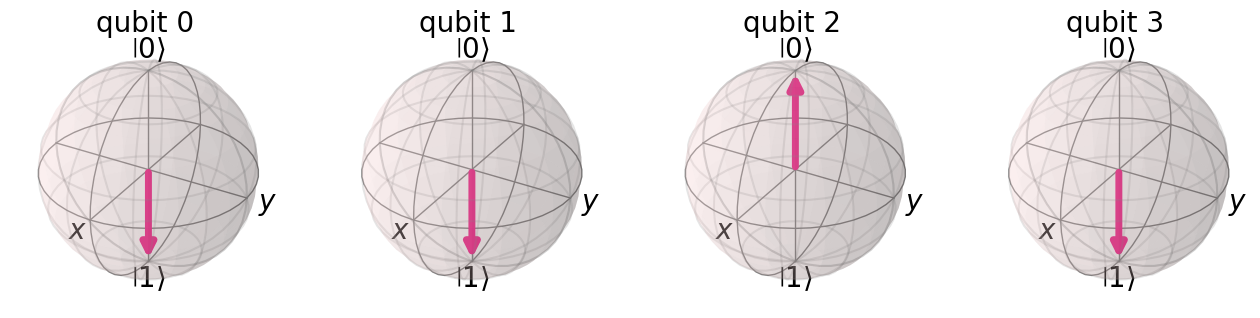

In [23]:
########################################### Beispiel ########################################################################################

qc = gen_circuit(13)        # circuit, der eine Zahl codiert

simulator = Aer.get_backend('statevector_simulator')        # Festlegen des Simulators der genutzt werden soll, hier Zustandsvektor-Simulator
result = simulator.run(transpile(qc, simulator)).result()   # um Zustand auf Bloch-Kugeln darzustellen
statevector = result.get_statevector()                      # Zustandsvektor wird gespeichert

plot_bloch_multivector(statevector)     # Zustandsvektoren der einzelnen Qubits werden auf Bloch-Kugeln dargestellt

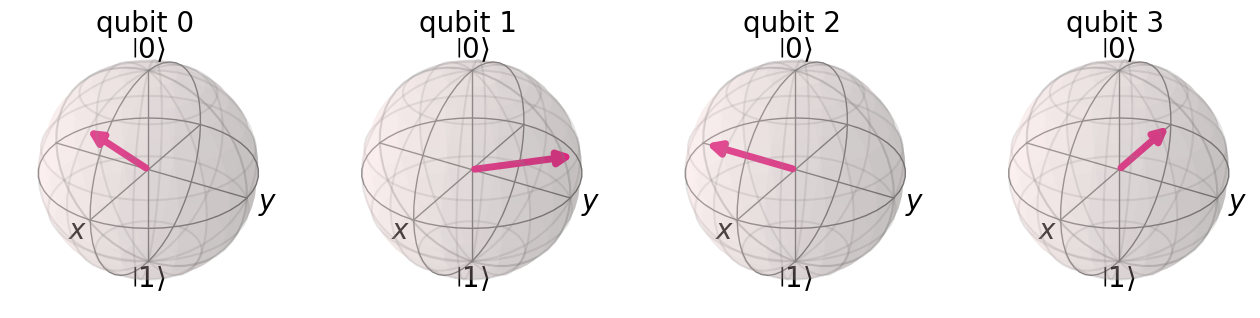

In [24]:
circ = qft(qc)      # qft des circuits wird durchgeführt

result = simulator.run(transpile(circ, simulator)).result()     
statevector = result.get_statevector()

plot_bloch_multivector(statevector) # Darstellen des fouriertransformierten circuits, als Zustände auf Bloch-Kugeln

In [25]:
circ = inverse_qft(circ)    # Anwenden der inversen qft
#circ.draw('mpl')

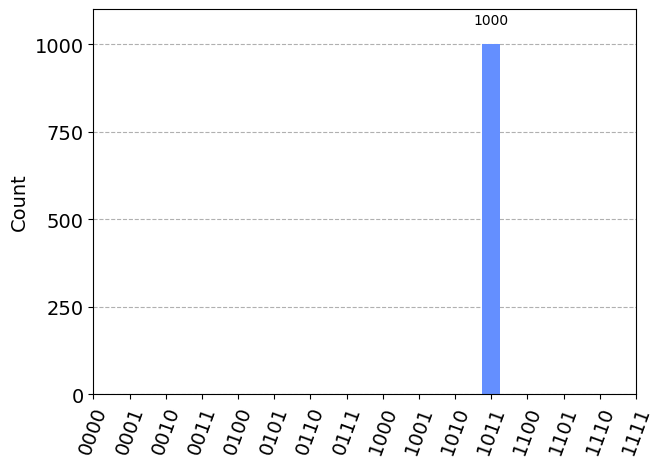

In [26]:
simulator = Aer.get_backend('qasm_simulator')   # Festlegen eines Simulators, hier QASM-Simulator, um counts der jeweiligen Zustände zu erhalten

circ.measure_all()      # Messen des Zustands
result = simulator.run(transpile(circ, simulator), shots=1000).result() # Simulation mit 1000 Durchläufen 
counts  = result.get_counts(circ)   # Speichern der counts

# Modifikation von counts, damit auch Zustände mit counts 0 im Histogramm angezeigt werden
for i in range(2**circ.num_qubits):
  bin = format(i, '0'+str(circ.num_qubits)+'b')

  if bin not in counts.keys():
    counts[bin] = 0

plot_histogram(counts)  # Darstellen, des Simulationsergebnisses im Histogramm